# Preprocessing and Feature Engineering

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
merged_df_clean  = pd.read_csv('Cleaned_merged_dataset.csv')

In [37]:
# Data type standardization
merged_df_clean['Year'] = merged_df_clean['Year'].astype(int)
merged_df_clean["State_name"] = merged_df_clean["State_name"].astype("category")
merged_df_clean["Age_group"] = merged_df_clean["Age_group"].astype("category")

merged_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40248 entries, 0 to 40247
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   State_name               40248 non-null  category
 1   State_code               40248 non-null  int64   
 2   Year                     40248 non-null  int64   
 3   Population               40248 non-null  int64   
 4   Sex                      40248 non-null  int64   
 5   Median_household_income  40248 non-null  float64 
 6   Age_label                40248 non-null  object  
 7   Age_group                40248 non-null  category
dtypes: category(2), float64(1), int64(4), object(1)
memory usage: 1.9+ MB


Year is saved as integer type to preserve temporal ordering. Also, State_name and Age_group are converted to categorical types in order to ensure appropriate grouping behaviors. The standardization step makes sure that the structure is consistent before advanced transformations. 

In [38]:
# Within-state income deviation
income_df = merged_df_clean[merged_df_clean['Age_group'] == 'All ages'].copy()

income_df["state_mean_income"] = (
    income_df.groupby("State_name")["Median_household_income"]
    .transform("mean")
)

income_df["income_within_state"] = (
    income_df["Median_household_income"]
    - income_df["state_mean_income"]
)

print(income_df['income_within_state'].mean())

income_df.head(5)

-5.596890472448789e-13


/var/folders/kn/zjhb2btj0hn5513h5_jjb6vw0000gn/T/ipykernel_7528/138944621.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  income_df.groupby("State_name")["Median_household_income"]


,State_name,State_code,Year,Population,Sex,Median_household_income,Age_label,Age_group,state_mean_income,income_within_state
0,Alabama,1,2021,5050380,0,53913.0,All ages,All ages,58599.666667,-4686.666667
1,Alabama,1,2022,5073903,0,59674.0,All ages,All ages,58599.666667,1074.333333
2,Alabama,1,2023,5108468,0,62212.0,All ages,All ages,58599.666667,3612.333333
258,Alabama,1,2021,2452912,1,53913.0,All ages,All ages,58599.666667,-4686.666667
259,Alabama,1,2022,2463660,1,59674.0,All ages,All ages,58599.666667,1074.333333


This variable captures how each state's income in a given year deviates from its own long-run average. 

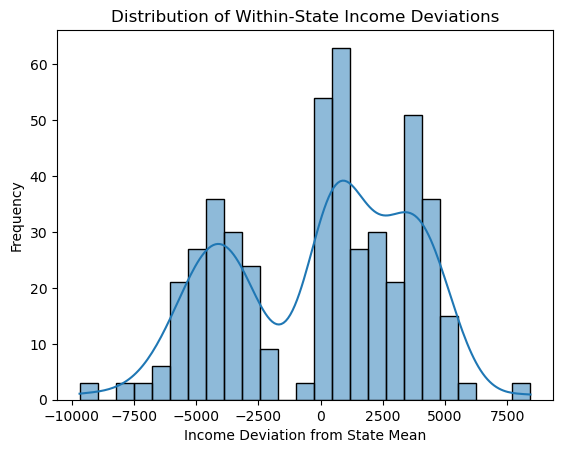

In [39]:
plt.figure()
sns.histplot(income_df["income_within_state"], bins=25, kde=True)
plt.title("Distribution of Within-State Income Deviations")
plt.xlabel("Income Deviation from State Mean")
plt.ylabel("Frequency")
plt.show()

After examining the distribution, it is obvious that:

- The mean of this variable is approximately 0.

- The distribution exhibits mild bimodality, suggesting heterogeneous performance across states.

- Deviations range roughly between −8,000 and +8,000, indicating substantial intra-state variability across years.

- The presence of both positive and negative tails reflects asymmetric temporal adjustments across states.

<Axes: xlabel='Year', ylabel='income_within_state'>

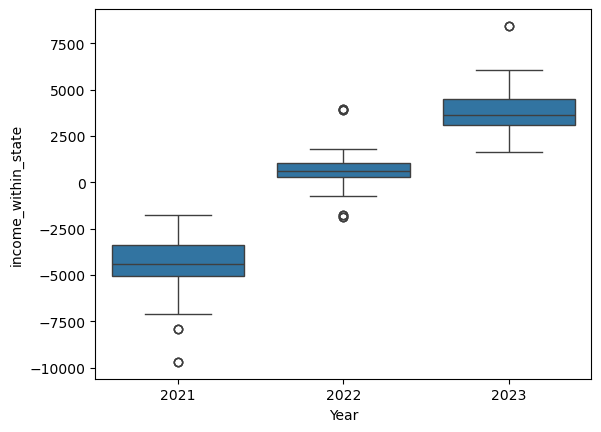

In [40]:
sns.boxplot(
    data=income_df,
    x="Year",
    y="income_within_state"
)

2021: mostly negative; 2022: positive shift; 2023: stabilization

In [41]:
# Income growth rate
income_df["income_growth_rate"] = (
    income_df.groupby("State_name")["Median_household_income"]
    .pct_change()
)

income_df.head(5)

/var/folders/kn/zjhb2btj0hn5513h5_jjb6vw0000gn/T/ipykernel_7528/3401012025.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  income_df.groupby("State_name")["Median_household_income"]


,State_name,State_code,Year,Population,Sex,Median_household_income,Age_label,Age_group,state_mean_income,income_within_state,income_growth_rate
0,Alabama,1,2021,5050380,0,53913.0,All ages,All ages,58599.666667,-4686.666667,NaN
1,Alabama,1,2022,5073903,0,59674.0,All ages,All ages,58599.666667,1074.333333,0.106857
2,Alabama,1,2023,5108468,0,62212.0,All ages,All ages,58599.666667,3612.333333,0.042531
258,Alabama,1,2021,2452912,1,53913.0,All ages,All ages,58599.666667,-4686.666667,-0.133399
259,Alabama,1,2022,2463660,1,59674.0,All ages,All ages,58599.666667,1074.333333,0.106857


This feature measures year-over-year percentage change in median income. In this way, we are asking how fast is a state growing economically. 

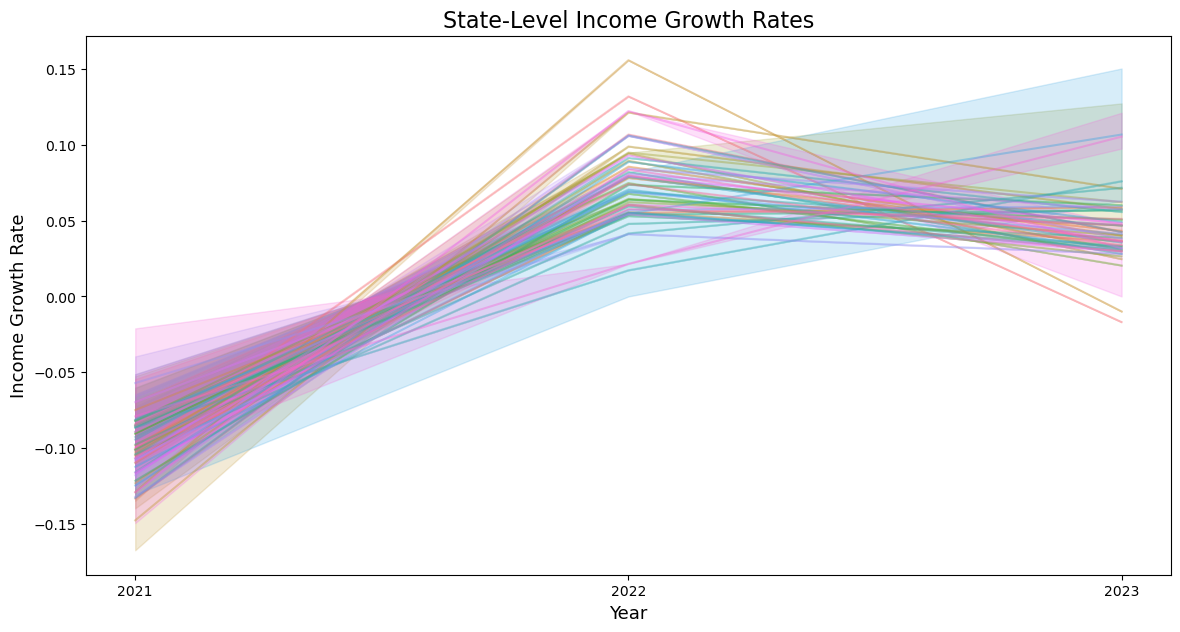

In [42]:
plt.figure(figsize=(14, 7))   

sns.lineplot(
    data=income_df,
    x="Year",
    y="income_growth_rate",
    hue="State_name",
    legend=False,
    alpha=0.4   
)

plt.title("State-Level Income Growth Rates", fontsize=16)
plt.xlabel("Year", fontsize=13)
plt.ylabel("Income Growth Rate", fontsize=13)

plt.xticks([2021, 2022, 2023])  
plt.show()


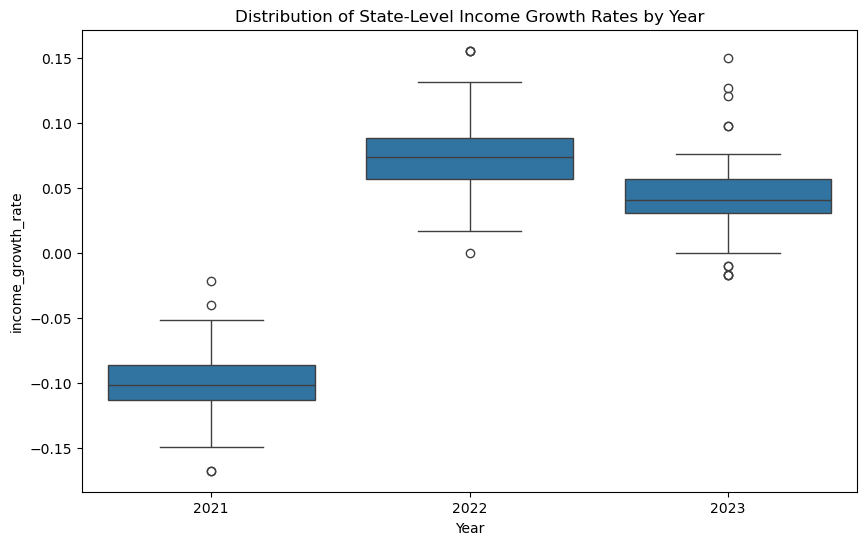

In [43]:
plt.figure(figsize=(10,6))

sns.boxplot(
    data=income_df,
    x="Year",
    y="income_growth_rate"
)

plt.title("Distribution of State-Level Income Growth Rates by Year")
plt.show()

We can easily see that growth rates were strongest between 2021 and 2022 and slowed slightly in 2023 for many states. In addition, variability across states is non-negligible. A few states show much higher volatility than the national average.

In [44]:
# Income volatility
state_stats = (
    income_df.groupby("State_name")["Median_household_income"]
    .agg(["mean","std"])
    .reset_index()
)

state_stats["cv"] = state_stats["std"] / state_stats["mean"]
state_stats_sorted = state_stats.sort_values("cv", ascending=False)
state_stats_sorted.head()

/var/folders/kn/zjhb2btj0hn5513h5_jjb6vw0000gn/T/ipykernel_7528/319484637.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  income_df.groupby("State_name")["Median_household_income"]


,State_name,mean,std,cv
8,District of Columbia,99775.000000,7903.038134,0.079209
45,Utah,87346.000000,6202.456711,0.071010
7,Delaware,78208.666667,5349.845302,0.068405
9,Florida,68558.666667,4472.920550,0.065242
0,Alabama,58599.666667,3682.797272,0.062847


Coefficient of variation measures dispersion relative to the mean. Unlike raw standard deviation, it controls for income scale differences.

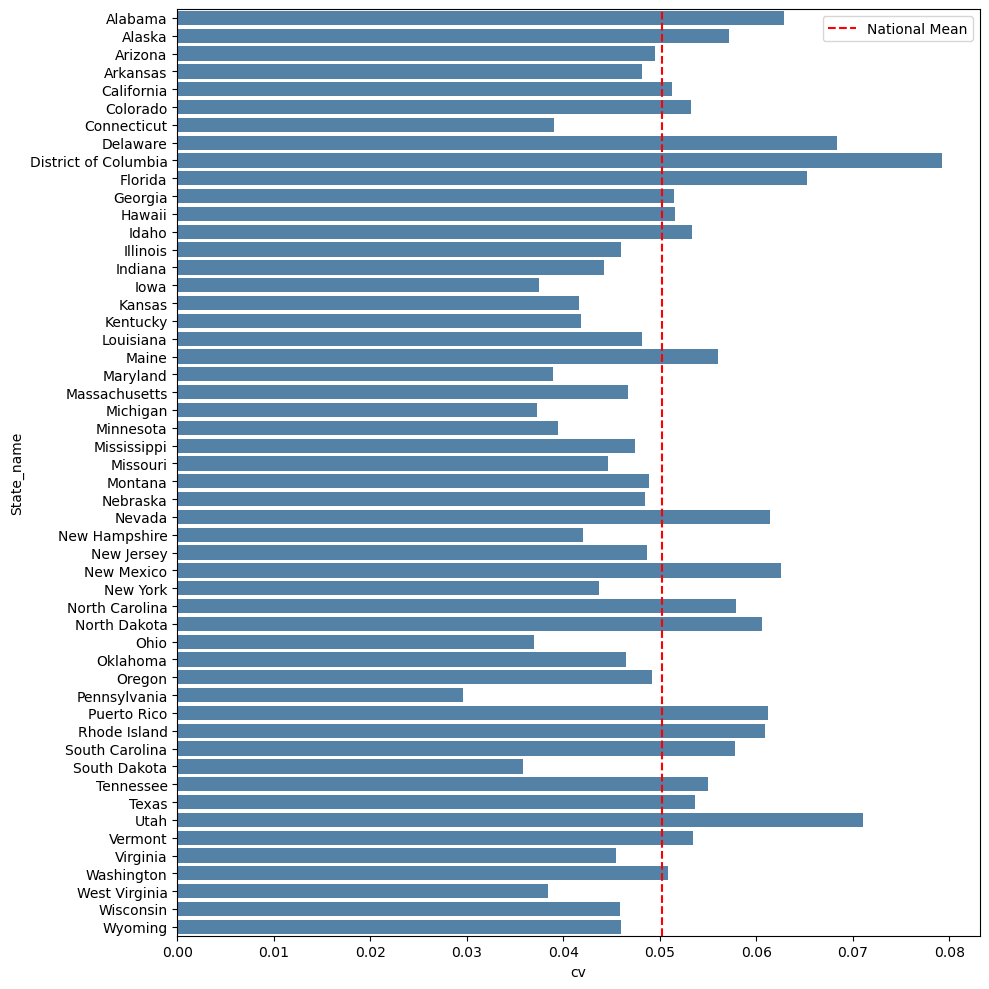

In [45]:
national_mean = state_stats["cv"].mean()

plt.figure(figsize=(10,10))

sns.barplot(
    data=state_stats_sorted,
    x="cv",
    y="State_name",
    color="steelblue"
)

plt.axvline(national_mean, color="red", linestyle="--", label="National Mean")

plt.legend()
plt.tight_layout()
plt.show()


The volatility ranking indicates that: first, high-income states do not necessarily exhibit higher relative volatility; second, some mid-income states display disproportionate fluctuation; third, several states show remarkably stable income trajectories across years.

In [46]:
national_mean = income_df.groupby("Year")["Median_household_income"].transform("mean")

income_df["income_relative_to_national"] = (
    income_df["Median_household_income"] - national_mean
)

income_df.sample(5)

,State_name,State_code,Year,Population,Sex,Median_household_income,Age_label,Age_group,state_mean_income,income_within_state,income_growth_rate,income_relative_to_national
30541,Pennsylvania,42,2022,6578161,2,71798.0,All ages,All ages,71526.333333,271.666667,0.041200,-1679.557692
26316,North Carolina,37,2021,10567100,0,61972.0,All ages,All ages,66752.333333,-4780.333333,NaN,-6367.788462
29413,Oregon,41,2022,4239379,0,75657.0,All ages,All ages,75793.000000,-136.000000,0.057223,2179.442308
14451,Louisiana,22,2021,2265685,1,52087.0,All ages,All ages,55244.000000,-3157.000000,-0.060073,-16252.788462
2153,Massachusetts,25,2023,3420435,1,99858.0,All ages,All ages,94663.666667,5194.333333,0.056833,23268.480769


This variable captures the difference between a state's income and the national average in the same year. It removes overall national trends and highlights each state's relative economic standing.

In [47]:
income_df["income_zscore_within_year"] = (
    income_df.groupby("Year")["Median_household_income"]
    .transform(lambda x: (x - x.mean()) / x.std())
)
income_df.sample(5)

,State_name,State_code,Year,Population,Sex,Median_household_income,Age_label,Age_group,state_mean_income,income_within_state,income_growth_rate,income_relative_to_national,income_zscore_within_year
31408,Rhode Island,44,2022,536381,1,81854.0,All ages,All ages,80278.000000,1576.000000,0.106016,8376.442308,0.600342
7377,District of Columbia,11,2022,352628,2,101027.0,All ages,All ages,99775.000000,1252.000000,0.121426,27549.442308,1.974476
30927,Rhode Island,44,2023,1095962,0,84972.0,All ages,All ages,80278.000000,4694.000000,NaN,8382.480769,0.575199
6871,District of Columbia,11,2022,318321,1,101027.0,All ages,All ages,99775.000000,1252.000000,0.121426,27549.442308,1.974476
5010,Colorado,8,2021,2943038,1,82254.0,All ages,All ages,88155.666667,-5901.666667,-0.078923,13914.211538,1.080501


This standardized income measure expresses each state's income in standard deviation units relative to the yearly national distribution, enabling scale-free comparison and outlier detection. Together, these two relative and standardized transformations improve interpretability, enhance comparability across states, and reduce scale effects, thereby increasing the analytical usefulness of the dataset.